### RoBERTa for Sentiment Analysis

In [1]:
from ast import literal_eval
import time
from typing import Union, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
import seaborn as sns

sns.set_style('whitegrid')

In [ ]:
!pip install transformers

In [2]:
import torch
import torch.nn.functional as F

In [3]:
import transformers
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig


In [4]:
def preprocess_text(text):
    '''Preprocess text: lowercase, remove newlines, strip'''
    return text.lower().replace('\n', ' ').strip()

In [6]:
# read Reddit posts and comments
data = pd.read_csv('./data/reddit_posts_nyc_apt.csv', index_col=0)

In [7]:
data.head()

,subreddit,title,score,num_comments,url,comments
0,r/NYCapartments,Midtown manhattan Studio with great view,1622,289,https://redd.it/1ditjh8,"['$5000 for a studio 😕', 'It comes with person..."
1,r/NYCapartments,"Spacious studio on the UWS, great location ste...",1434,57,https://redd.it/1at9s69,"['When can I move in?', 'Wow! What a steal!', ..."
2,r/NYCapartments,Those with high rise skyline apartments do you...,1338,249,https://redd.it/1fwnevs,['I didn’t live in one but I worked at an offi...
3,r/NYCapartments,The rent crisis in NYC is becoming increasingl...,1256,371,https://redd.it/1aq7si7,"['Two incomes no kids.', 'Tell me about it, I ..."
4,r/NYCapartments,Happy Monday everyone,944,199,https://redd.it/1auv5ws,['I think average salary context is needed. Ta...


In [8]:
data.shape

(200, 6)

In [9]:
# turn comments to list
data.comments = data.comments.apply(literal_eval)
# Apply preprocessing
data['cleaned_text'] = data['comments'].apply(lambda x: " ".join(preprocess_text(comment) for comment in x if comment))

In [21]:
# How many comments do we have on posts?
data.comments.map(lambda x: len(x)).sum()

9825

In [10]:
data.cleaned_text[:10]

0    $5000 for a studio 😕 it comes with personal tr...
1    when can i move in? wow! what a steal! pets? 3...
2    i didn’t live in one but i worked at an office...
3    two incomes no kids. tell me about it, i liter...
4    i think average salary context is needed. take...
5    that's tough if you need a work desk in there ...
6    literally all 1 bedrooms for less than 3k is a...
7    guest fee is wild the guest fee doesn't sound ...
8    everyone is different so make the best choice ...
9    yeah, it fucking sucks and just keeps getting ...
Name: cleaned_text, dtype: object

In [11]:
def predict_sentiment(text: str, model: AutoModelForSequenceClassification, 
                      tokenizer: AutoTokenizer, max_length:int = 512):
    '''
    Predicts the sentiment of a text using a pre-trained model and tokenizer.

    Parameters
    ----------
    text: str
        String with input text
    model: transformers.AutoModelForSequenceClassification
        The pre-trained model.
    tokenizer: transformers.AutoTokenizer
        The pre-trained tokenizer.
    max_length: (int, optional)
        The maximum sequence length accepted by the model. Default is 512.

    Returns
    -------
    transformers.SequenceClassifierOutput
      The model's output, including predicted labels and probabilities.
    '''

    # Tokenize the text
    encoded_input = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

    # Check if any of the token IDs in the input are the unknown token ID (OOV).
    input_ids = encoded_input['input_ids']
    oov_indices = [i for i, token_id in enumerate(input_ids[0]) if token_id == tokenizer.unk_token_id]
    if oov_indices:
        print(f"Warning: Found {len(oov_indices)} OOV tokens at positions: {oov_indices} in text: {text}")

    # Get position IDs and check for out-of-range positions
    # where the positions are greater than vocab size
    position_ids = torch.arange(0, input_ids.shape[1], dtype=torch.long,
                                device=input_ids.device)
    out_of_range_positions = [i for i, pos_id in enumerate(position_ids) if pos_id >= tokenizer.vocab_size]
    if out_of_range_positions:
        print(f"Warning: Found {len(out_of_range_positions)} position IDs out of range: {out_of_range_positions} in text: {text}")

    # Perform inference
    with torch.no_grad(): # Disable gradient calculation during inference
        output = model(**encoded_input)

    return output

In [12]:
def interpret_sentiment(output):
    """Interprets the sentiment from the model's output.

    Parameters
    ----------
        output: transformers.SequenceClassifierOutput:
        The model's output.

    Returns
    -------
        dict: A dictionary containing the predicted sentiment label and its probability.
               e.g., {'label': 'positive', 'prob': 0.95}
    """
    # Calculate the probabilities of each sentiment using softmax
    probs = F.softmax(output.logits, dim=1)

    # Get the predicted label (index of the highest probability)
    predicted_label_index = torch.argmax(probs).item()

    # Map the label index to a sentiment label
    sentiment_mapping = {
        0: "negative",
        1: "neutral",
        2: "positive"
    }
    predicted_label = sentiment_mapping.get(predicted_label_index, "unknown")

    # Get the probability of the predicted label
    predicted_prob = probs[0][predicted_label_index].item()

    # Return the label and probability as a dictionary
    return {'label': predicted_label, 'prob': predicted_prob}

In [13]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


In [15]:
start_time = time.time()
# Predict sentiment based on cleaned_text column
# this return sentiment output with logit values
data['sentiment_output'] = data['cleaned_text'].apply(lambda text: predict_sentiment(text, model, tokenizer))
end_time = time.time()
print(f'Took {end_time-start_time} ms to predict sentiments')
print(f'Took {(end_time-start_time)/60.0} mins to predict sentiments')

Took 62.20491886138916 ms to predict sentiments
Took 1.0367486476898193 mins to predict sentiments


In [ ]:
# look at one output
data.sentiment_output.iloc[0]

SequenceClassifierOutput(loss=None, logits=tensor([[-0.7412,  0.1882,  0.6755]]), hidden_states=None, attentions=None)

### Interpret sentiment output

In [ ]:
# get sentiment prediction and probability from output
data['sentiment_dict'] = data['sentiment_output'].apply(interpret_sentiment)

In [24]:
# extract sentiment and probabilities into 2 separate columns
data['sentiment'] = data.sentiment_dict.map(lambda x: x['label'])
data['sentiment_prob'] = data.sentiment_dict.map(lambda x: x['prob'])

In [66]:
data.head(2)

,subreddit,title,score,num_comments,url,comments,cleaned_text,sentiment_output,sentiment_dict,sentiment,sentiment_prob
0,r/NYCapartments,Midtown manhattan Studio with great view,1622,289,https://redd.it/1ditjh8,"[$5000 for a studio 😕, It comes with personal ...",$5000 for a studio 😕 it comes with personal tr...,"{'logits': [[tensor(-0.7412), tensor(0.1882), ...","{'label': 'positive', 'prob': 0.5385749936103821}",positive,0.538575
1,r/NYCapartments,"Spacious studio on the UWS, great location ste...",1434,57,https://redd.it/1at9s69,"[When can I move in?, Wow! What a steal!, Pets...",when can i move in? wow! what a steal! pets? 3...,"{'logits': [[tensor(0.6609), tensor(0.3187), t...","{'label': 'negative', 'prob': 0.5297321677207947}",negative,0.529732


In [ ]:
# write to csv
data.to_csv('reddit_posts_nyc_apt_sentiment_roberta.csv')

In [39]:
# sample some comments and print their sentiment and probabilities
for ix, row in data[['cleaned_text','sentiment','sentiment_prob']].sample(3).iterrows():
  print(f"{row['cleaned_text'][:200]}")
  print(f"Sentiment: {row['sentiment']}")
  print(f"Probability: {row['sentiment_prob']}\n")

congratulations what site did you use for a rent stabilized place? my first place in nyc 10 years ago was a room with 4 other roommates in a walk up. fast forward 10 years and my dream apartment (also
Sentiment: positive
Probability: 0.9298062920570374

34 market is a great example of this tax being totally needed   also my building is half empty and units are infested with rats because no none lives in them   some have broken windows which makes the
Sentiment: negative
Probability: 0.5994457006454468

bring back mitchell llama and public housing developments, if the private sector won’t build, swing the pendulum back to the public sector.  watch the prices drop as supply returns. i have very little
Sentiment: neutral
Probability: 0.5356485843658447



### Notes

* Model Raw Scores - logits
* Softmax converts logits into a probability distribution that represents the models
confidence in each possible class. 
* This allows for easier interpretation and decision-making based on the predicted probabilities.

Example: <br>
* The original logits [-1, 0, 2] represent the model's raw scores for each sentiment class.
* After applying softmax, we get the probabilities [0.045, 0.119, 0.835].
* These probabilities can be interpreted as follows:
  * There's a 4.5% probability the text is negative.
  * There's an 11.9% probability the text is neutral.
  * There's an 83.5% probability the text is positive.


In [41]:
# we notice that sentiment probability averages tend toward what we expect
# high sentiment probability for positive and negative (vs neutral)
data.groupby('sentiment').sentiment_prob.describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,82.0,0.686536,0.138038,0.435413,0.579771,0.701064,0.791551,0.946154
neutral,46.0,0.494293,0.053438,0.386881,0.465982,0.500891,0.527618,0.641039
positive,72.0,0.739631,0.174016,0.393352,0.589238,0.753418,0.904534,0.987342


## Data Visualization

* Sentiment distribution - a big majority of comments are negative
* Sentiment probability distributions: positive and negative are wider ranging and neutral is smallest



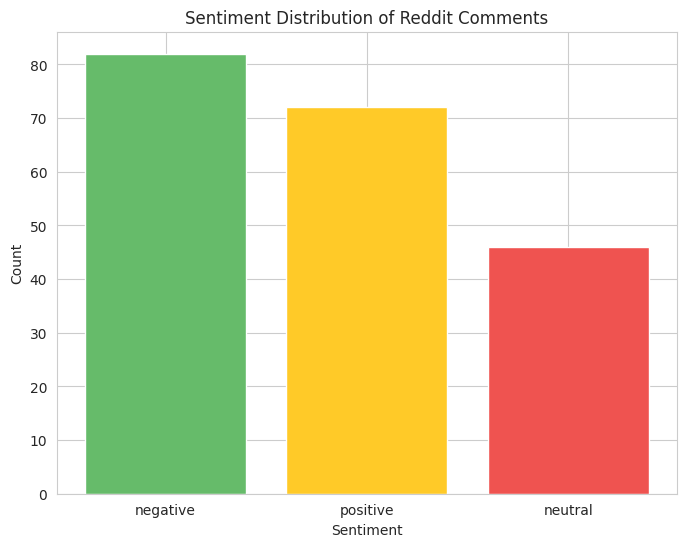

In [33]:
# sentiment values
sentiment_df = data.sentiment.value_counts().reset_index()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_df['sentiment'], sentiment_df['count'], color=['#66BB6A', '#FFCA28', '#EF5350'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution of Reddit Comments')
plt.show()


Text(0, 0.5, 'Frequency')

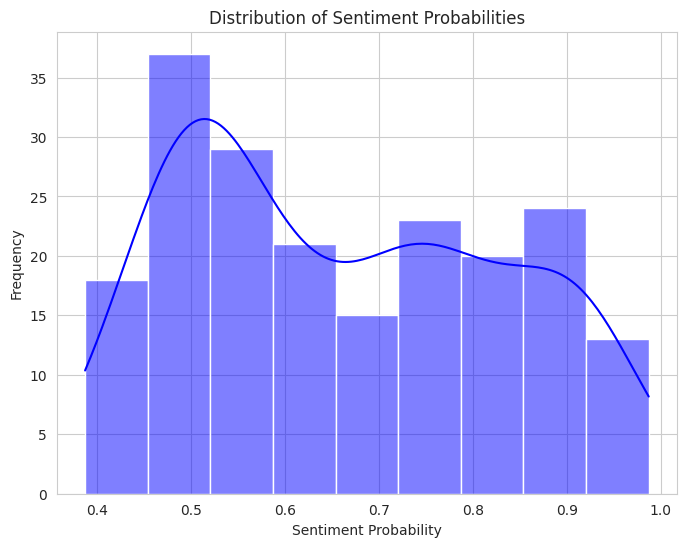

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data.sentiment_prob, ax=ax, kde=True, color='Blue')
ax.set_title('Distribution of Sentiment Probabilities')
ax.set_xlabel('Sentiment Probability')
ax.set_ylabel('Frequency')

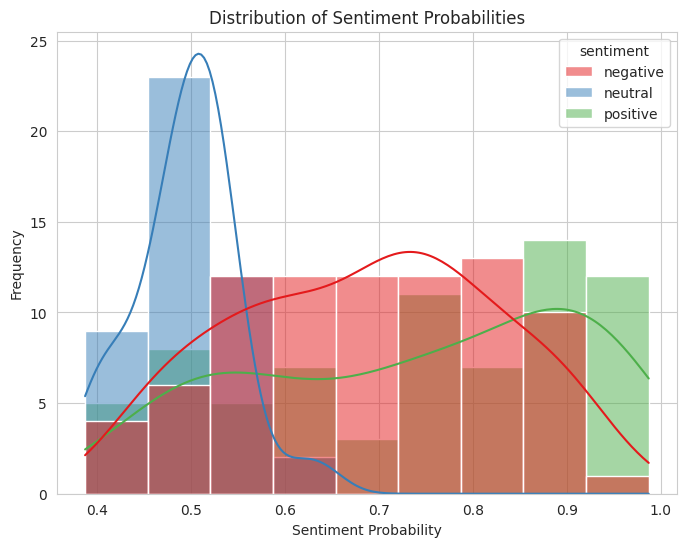

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data, x='sentiment_prob', hue='sentiment', ax=ax, kde=True,
             hue_order=['negative', 'neutral', 'positive'],
             palette='Set1')
_ = ax.set_title('Distribution of Sentiment Probabilities')
_ = ax.set_xlabel('Sentiment Probability')
_ = ax.set_ylabel('Frequency')

In [42]:
sentiment_counts = data.sentiment.value_counts().reset_index()
sentiment_counts

,sentiment,count
0,negative,82
1,positive,72
2,neutral,46


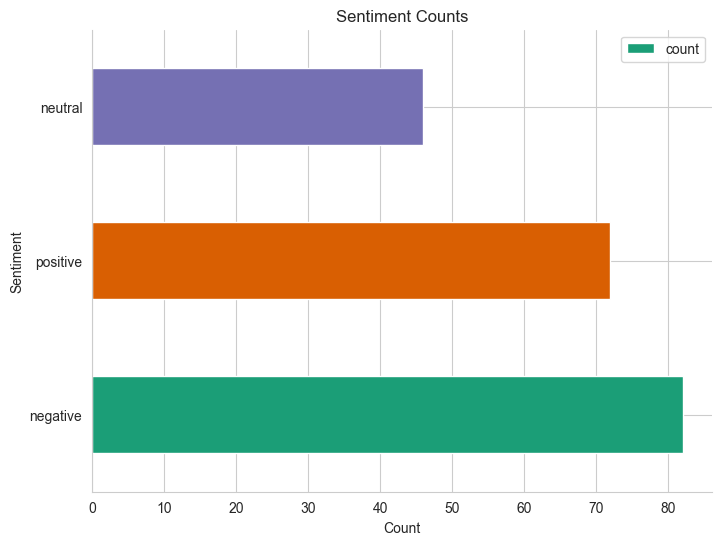

In [43]:
# plot sentiment counts
fig, ax = plt.subplots(figsize=(8, 6))
g = sentiment_counts.plot(kind='barh', x = 'sentiment', y ='count',
                      color=sns.palettes.mpl_palette('Dark2'), ax=ax)
_ = plt.xlabel('Count')
_ =  plt.ylabel('Sentiment')
_ =  plt.title('Sentiment Counts')
_ =  plt.gca().spines[['top', 'right',]].set_visible(False)

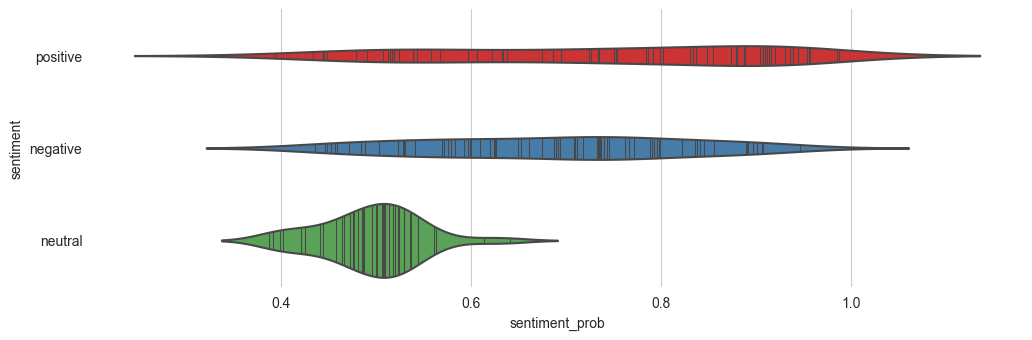

In [47]:
# sentiment vs sentiment_prob

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='sentiment_prob', y='sentiment', inner='stick', palette='Set1')
sns.despine(top=True, right=True, bottom=True, left=True)